## Importing Classes


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/smiles_project/smiles2spec/")
#print(os.getcwd())
#print(os.listdir())  # should show 'smiles2spec'


/content/drive/.shortcut-targets-by-id/1jfgh5M7cyb9I0chqy6_LN1s1OAEzg9-e/smiles_project/smiles2spec
['smiles2spec', 'GitHub_instructions.txt', 'README.md', '.gitignore', 'Example_Notebook.ipynb', '.git', 'notebooks']


In [ ]:
import torch
import torch.nn as nn

In [ ]:
from smiles2spec.models import Smile2Spec
from smiles2spec.train import SIDLoss

## Model


In [ ]:
args = {
    'model_name':"DeepChem/ChemBERTa-5M-MTR",
    'output_activation':'exp',
    'norm_range': (50, 550),
    'dropout': 0.2,
    'activation': nn.ReLU(),
    'ffn_num_layers': 0,          # 0, 1, 3, 5, 10
    'ffn_hidden_dim': 2200,       # hidden dim of the FFN
    'ffn_output_dim': 1801        # output dim of the FFN
}


In [ ]:
class Smile2Spec(nn.Module):
    """A Smile2Spec model contains a LLM head, followed by a Feed Forward MLP."""
    def __init__(self, args):
        """
        Initializes the Smile2Spec model.
        :param args: argument for building the model."""

        super(Smile2Spec, self).__init__()

        # LLM
        self.LLM = AutoModelForSequenceClassification.from_pretrained(args.get('model_name'))

        # Internal params
        if "ChemBERTa" in args.get('model_name'): # my fix XXX

            input_dim = self.LLM.classifier.out_proj.out_features

        if "ChemGPT" in args.get('model_name'): # my fix XXX

            self.LLM.config.pad_token_id = self.LLM.config.eos_token_id
            input_dim = self.LLM.score.out_features

        self.output_activation = args.get('output_activation')
        self.norm_range = args.get('norm_range')

        # FFN params
        dropout = nn.Dropout(args.get('dropout'))
        activation = args.get('activation')

        # New classification head
        # First layer
        if args.get('ffn_num_layers') == 0:
            output_dim = args.get('ffn_output_dim')
        else:
            output_dim = args.get('ffn_hidden_dim')

        ffn = [activation, dropout, nn.Linear(input_dim, output_dim)]

        # Next layers
        input_dim = args.get('ffn_hidden_dim')
        output_dim = args.get('ffn_hidden_dim')

        for l in range(args.get('ffn_num_layers')):

            if l == (args.get('ffn_num_layers') - 1):
                output_dim = args.get('ffn_output_dim')

            ffn.extend([activation, dropout, nn.Linear(input_dim, output_dim)])

        self.ffn = nn.Sequential(*ffn)

    def forward(self,
                input_ids = None,
                attention_mask = None,
                labels=None):
        """
        Runs the Smile2Spec model on input.

        :return: Output of the Smile2Spec model."""

        #Compute LLM output.
        LLM_output = self.LLM(input_ids,
                              attention_mask=attention_mask).logits # type: ignore

        #Compute ffn output.
        output = self.ffn(LLM_output)

        # Positive value
        if self.output_activation == 'exp':
            output = torch.exp(output)
        if self.output_activation == 'relu':
            f = nn.ReLU()
            output = f(output)

        # Normalization
        if self.norm_range is not None:
            norm_data = output[:, self.norm_range[0]:self.norm_range[1]]
            norm_sum = torch.sum(norm_data, 1)
            norm_sum = torch.unsqueeze(norm_sum, 1)
            output = torch.div(output, norm_sum)

        return output

In [ ]:
from transformers import AutoModelForSequenceClassification

model = Smile2Spec(args)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
file_path = "/content/drive/My Drive/smiles_project/storage/smiles2spec_models/smiles_comp_ChemBERTa-5M-MTR_FFNN-0-2200/model.pt"
# load stored model parameters
state_dict = torch.load(file_path, weights_only=False, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Smile2Spec(
  (LLM): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(600, 384, padding_idx=1)
        (position_embeddings): Embedding(515, 384, padding_idx=1)
        (token_type_embeddings): Embedding(1, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.144, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-2): 3 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.109, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): L

## Loss


In [ ]:
sid = SIDLoss()

In [ ]:
sid(torch.randn(1, 100), torch.randn(1, 100))

tensor(987.5192)

## Predictions


In [ ]:
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm

# SMILES csv
df = pd.read_csv("/content/drive/MyDrive/smiles_project/storage/results/decoded_predictions_1500.csv")

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")

# collect spectra predictions
spectra_preds = []

# generate spectra for each Pred_SMILES
for smile in tqdm(df['Pred_SMILES'].fillna(""), desc="Predicting Spectra"):
    try:
        tokenized = tokenizer(smile, return_tensors='pt')
        with torch.no_grad():
            spectrum = model(**tokenized)
        spectra_preds.append(spectrum.squeeze(0).cpu().numpy())
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        spectra_preds.append(None)

"""
test_SMILE = 'COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3ccccc32)cc1'
tokenized_smile = tokenizer(test_SMILE, return_tensors='pt')
model(**tokenized_smile)
"""

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

Predicting Spectra: 100%|██████████| 1500/1500 [00:24<00:00, 60.96it/s]


"\ntest_SMILE = 'COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3ccccc32)cc1'\ntokenized_smile = tokenizer(test_SMILE, return_tensors='pt')\nmodel(**tokenized_smile)\n"

In [ ]:
import numpy as np


org_csv_path = "/content/drive/My Drive/smiles_project/computed_spectra.csv"
pred_csv = "/content/drive/My Drive/smiles_project/storage/results/decoded_predictions_1500.csv"

# load large dataset with spectra
df_large = pd.read_csv(org_csv_path)  # full smiles + spectra
df_large.columns.values[0] = "smiles"

# load smaller file with true SMILES
df_small = pd.read_csv(pred_csv)

# merge on SMILES -> get corresponding spectra
merged_df = df_small.merge(df_large, left_on="True_SMILES", right_on="smiles", how="left")

# extract only the spectra columns (columns 1–1801 in df_large = columns -1801: in merged_df)
Y_true = merged_df.iloc[:, -1801:].values  # numpy array of shape (N, 1801)


#Y_true = np.array(df['True_Spectra'].tolist())  # shape: (1500, 1801)
print("Y_true shape:", Y_true.shape)

Y_true shape: (1500, 1801)


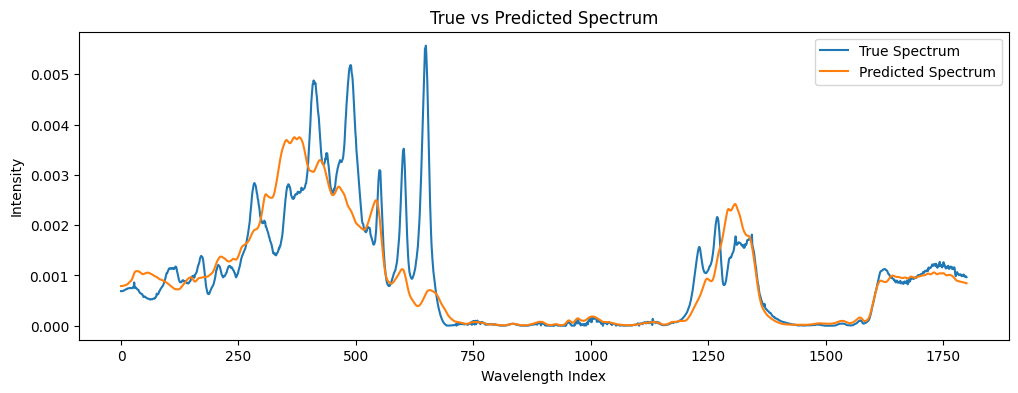

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# stack all predicted spectra into a numpy array
Y_pred = np.stack([s for s in spectra_preds if s is not None])

# smoothing
Y_pred_smoothed = gaussian_filter(Y_pred, sigma=3)

idx = 0

plt.figure(figsize=(12, 4))
plt.plot(Y_true[idx], label="True Spectrum")
plt.plot(Y_pred_smoothed[idx], label="Predicted Spectrum")
plt.title("True vs Predicted Spectrum")
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.legend()
plt.show()


In [ ]:
# convert arrays to lists
df_small['True_Spectra'] = [list(row) for row in Y_true]
df_small['Pred_Spectra'] = [list(row) for row in Y_pred]

# save everything to csv file
df_small.to_csv("predicted_with_spectra_1500.csv", index=False)


In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity
from difflib import SequenceMatcher

def sanitize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToSmiles(mol) if mol is not None else None
    except:
        return None

def tanimoto(s1, s2):
    try:
        mol1 = Chem.MolFromSmiles(s1)
        mol2 = Chem.MolFromSmiles(s2)
        if mol1 is None or mol2 is None:
            return 0.0
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2)
        return TanimotoSimilarity(fp1, fp2)
    except:
        return 0.0

def syntax_similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()


In [ ]:
# sanitize first
df['True_SMILES_clean'] = df['True_SMILES'].apply(sanitize_smiles)
df['Pred_SMILES_clean'] = df['Pred_SMILES'].apply(sanitize_smiles)

# drop rows with invalid SMILES
df_valid = df.dropna(subset=['True_SMILES_clean', 'Pred_SMILES_clean'])

# compute similarities
df_valid['Tanimoto'] = df_valid.apply(lambda row: tanimoto(row['True_SMILES_clean'], row['Pred_SMILES_clean']), axis=1)
df_valid['Syntax'] = df_valid.apply(lambda row: syntax_similarity(row['True_SMILES_clean'], row['Pred_SMILES_clean']), axis=1)


[20:48:06] SMILES Parse Error: extra close parentheses while parsing: CCCCN)c1ccccc1
[20:48:06] SMILES Parse Error: check for mistakes around position 6:
[20:48:06] CCCCN)c1ccccc1
[20:48:06] ~~~~~^
[20:48:06] SMILES Parse Error: Failed parsing SMILES 'CCCCN)c1ccccc1' for input: 'CCCCN)c1ccccc1'
[20:48:06] SMILES Parse Error: extra close parentheses while parsing: CF)CBr
[20:48:06] SMILES Parse Error: check for mistakes around position 3:
[20:48:06] CF)CBr
[20:48:06] ~~^
[20:48:06] SMILES Parse Error: Failed parsing SMILES 'CF)CBr' for input: 'CF)CBr'
[20:48:06] SMILES Parse Error: syntax error while parsing: ]nnnnnnnnnnn
[20:48:06] SMILES Parse Error: check for mistakes around position 1:
[20:48:06] ]nnnnnnnnnnn
[20:48:06] ^
[20:48:06] SMILES Parse Error: Failed parsing SMILES ']nnnnnnnnnnn' for input: ']nnnnnnnnnnn'
[20:48:06] SMILES Parse Error: extra close parentheses while parsing: C1CCCC=C1F)C=N2
[20:48:06] SMILES Parse Error: check for mistakes around position 11:
[20:48:06] C1CC

In [ ]:
total_rows = len(df)
valid_rows = len(df_valid)

print(f"\nValid SMILES: {valid_rows} / {total_rows} ({valid_rows / total_rows:.2%})\n")

print("Tanimoto Similarity Statistics:")
print(df_valid['Tanimoto'].describe())

print("\nSyntax Similarity Statistics:")
print(df_valid['Syntax'].describe())



Valid SMILES: 629 / 1500 (41.93%)

Tanimoto Similarity Statistics:
count    629.000000
mean       0.091247
std        0.041825
min        0.000000
25%        0.064103
50%        0.088608
75%        0.112676
max        0.461538
Name: Tanimoto, dtype: float64

Syntax Similarity Statistics:
count    629.000000
mean       0.324016
std        0.117810
min        0.000000
25%        0.250000
50%        0.318841
75%        0.400000
max        0.800000
Name: Syntax, dtype: float64


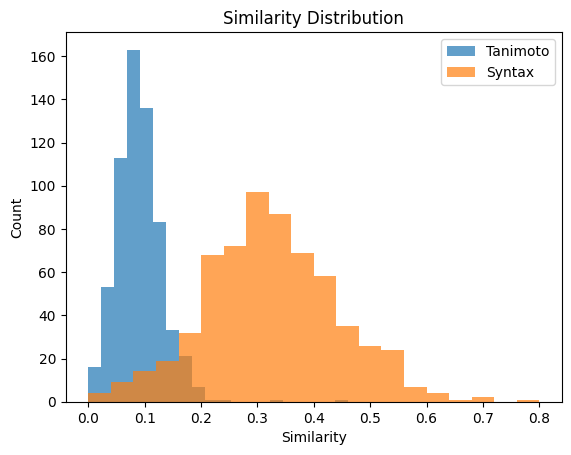

In [ ]:
plt.hist(df_valid['Tanimoto'], bins=20, alpha=0.7, label='Tanimoto')
plt.hist(df_valid['Syntax'], bins=20, alpha=0.7, label='Syntax')
plt.legend()
plt.title("Similarity Distribution")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()

[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator
[20:48:08] DEPRECATION WARNING: please use MorganGenerator


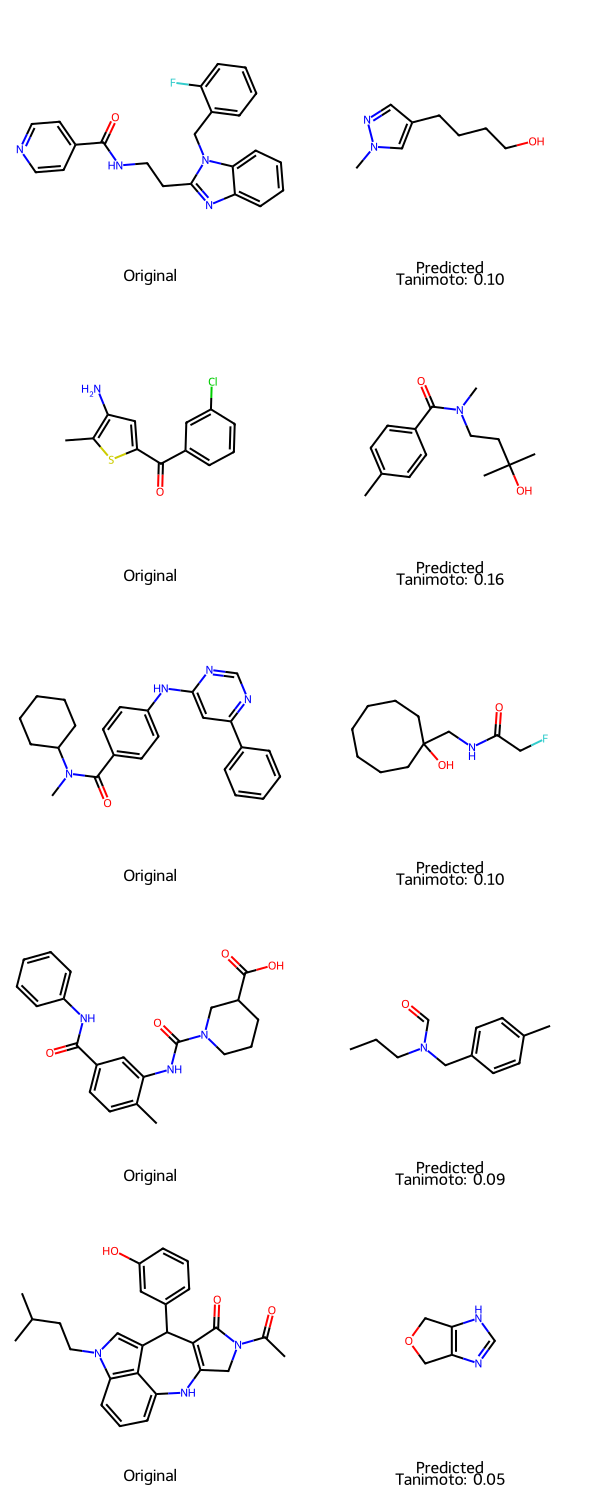

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
import random

# sample size
n_to_show = 5

# drop rows with invalid molecules
df_valid = df_valid.dropna(subset=['True_SMILES', 'Pred_SMILES'])

# sample n pairs randomly
sampled_df = df_valid.sample(n=n_to_show, random_state=42).reset_index()

# store molecules and similarities
combined_mols = []
legends = []

for _, row in sampled_df.iterrows():
    smi1 = row['True_SMILES']
    smi2 = row['Pred_SMILES']

    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)

    if mol1 is None or mol2 is None:
        continue  # skip invalid molecules

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    sim = TanimotoSimilarity(fp1, fp2)

    combined_mols.extend([mol1, mol2])
    legends.extend([
        "Original",
        f"Predicted\nTanimoto: {sim:.2f}"
    ])

# grid
img = MolsToGridImage(
    combined_mols,
    molsPerRow=2,
    subImgSize=(300, 300),
    legends=legends
)
img
